# Plot changes in the Metabolic index

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import os

import grid_tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cartopy.util import add_cyclic_point
import plot_tools
from config_calc import *
import cmocean

import solubility
import constants

plt.rcParams['mathtext.default']='regular'

### make grid

In [2]:
nx = 360
ny = 180
grid = grid_tools.generate_latlon_grid(nx=nx,ny=ny,lon0=0.)
grid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, nv: 4)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Dimensions without coordinates: nv
Data variables:
    xc       (lat, lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
    yc       (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    xv       (lat, lon, nv) float64 0.0 1.0 1.0 0.0 1.0 2.0 2.0 1.0 2.0 3.0 ...
    yv       (lat, lon, nv) float64 -90.0 -90.0 -89.0 -89.0 -90.0 -90.0 ...
    area     (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 1.079e+08 ...

In [3]:
depth = xr.DataArray(np.concatenate((np.arange(0.,40.,10.),
                                     np.arange(50.,175.,25.),
                                     np.arange(200.,350.,50.),
                                     np.arange(400.,1600.,100.),
                                     np.arange(1750.,2000.,250.),
                                     np.arange(2000.,6500.,500.))),dims=('depth'))

dz = depth.diff(dim='depth')
depth = depth.isel(depth=slice(0,-1))
print depth
print dz

<xarray.DataArray (depth: 33)>
array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,   150.,
         200.,   250.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1750.,  2000.,  2500.,
        3000.,  3500.,  4000.,  4500.,  5000.,  5500.])
Dimensions without coordinates: depth
<xarray.DataArray (depth: 33)>
array([  10.,   10.,   10.,   20.,   25.,   25.,   25.,   25.,   50.,   50.,
         50.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  250.,  250.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.])
Dimensions without coordinates: depth


### load data from Curtis

In [4]:
import scipy.io as sio
matdata = sio.loadmat('data/IUCN_MetabIndex.mat', struct_as_record=False, squeeze_me=True)

#### read CMIP5 model data

monthly fields are really just annual means

In [5]:
val = matdata['EM']
EM = {}
for k in ['do2','dt']:
    EM[k.upper()] = xr.DataArray(val.__dict__[k],dims=('model','lon','lat','depth','month'),coords={'lon':grid.lon,'lat':grid.lat,'depth':depth})
EM = xr.Dataset(EM)
EM = EM.transpose('month','depth','lat','lon','model')
EM

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 180, lon: 360, model: 5, month: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Dimensions without coordinates: model, month
Data variables:
    DO2      (month, depth, lat, lon, model) float64 nan nan nan nan nan nan ...
    DT       (month, depth, lat, lon, model) float64 nan nan nan nan nan nan ...

#### read the WOA2009 dataset

In [6]:
val = matdata['WOA']
WOA = {}
for k in val.__dict__['_fieldnames']:
    x = val.__dict__[k]
    if x.ndim == 4:
        key = k 
        if key not in ['pO2','pCO2']: key = key.upper()
        WOA[key] = xr.DataArray(x,dims=('lon','lat','depth','month'),coords={'lon':grid.lon,'lat':grid.lat,'depth':depth})
WOA = xr.Dataset(WOA)
WOA = WOA.transpose('month','depth','lat','lon')
WOA    

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 180, lon: 360, month: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Dimensions without coordinates: month
Data variables:
    TEMP     (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    pO2      (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    AOU      (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    pCO2     (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    SALT     (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2       (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...

#### compute changes in the environment

In [7]:
#-- change in temperature
dT = EM.DT.mean(dim='model')
Tfut = WOA.TEMP + dT

#-- change in oxygen (don't trust O2 change in anoxic regions, so mask where O2 <= 1.)
dO2 = EM.DO2.mean(dim='model').where(WOA.O2 > 1.).fillna(0.).where(~np.isnan(WOA.O2)) 
O2fut = WOA.O2 + dO2
O2fut = O2fut.where(O2fut > 0.).fillna(0.).where(~np.isnan(WOA.O2)) # don't let O2 go negative

#-- compute the future pO2
Z = WOA.depth * xr.DataArray(np.ones((len(WOA.lat),len(WOA.lon))),dims=('lat','lon'))
Khfut = solubility.O2_Kh(WOA.SALT,Tfut,Z)
pO2fut = O2fut / Khfut
dpO2 = pO2fut - WOA.pO2

/glade/p/work/mclong/miniconda2/lib/python2.7/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


combine in dataset

In [8]:
ds = xr.Dataset({'O2':WOA.O2,'dO2':dO2,'TEMP':WOA.TEMP,'dT':dT,'pO2':WOA.pO2,'dpO2':dpO2,
                'O2fut':O2fut,'Tfut':Tfut,'pO2fut':pO2fut})
ds

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 180, lon: 360, month: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
Dimensions without coordinates: month
Data variables:
    Tfut     (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    TEMP     (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    dpO2     (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    dO2      (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    dT       (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    pO2      (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2       (month, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    pO2fut   (month, depth, lat, lon) float64 nan nan nan nan nan nan nan 

#### make some quick plots, make sure everything looks ok

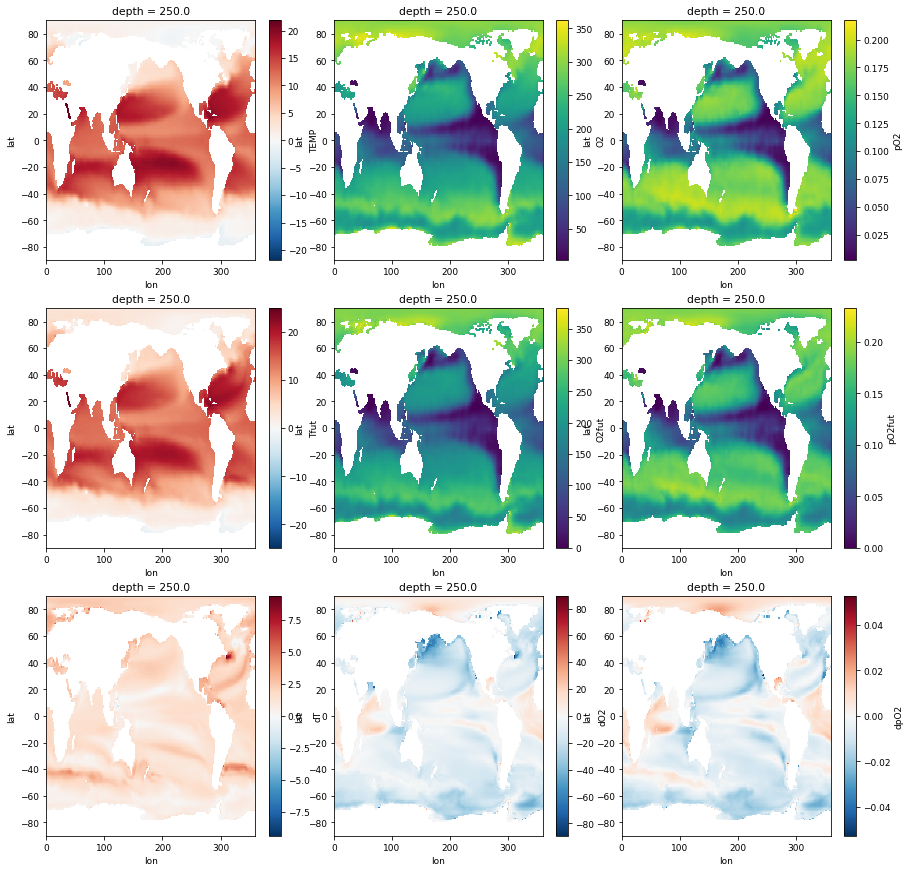

In [9]:
k = 10

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

#--- temp
ax = fig.add_subplot(gs[0,0])
ds.mean(dim='month').TEMP[k,:,:].plot()

ax = fig.add_subplot(gs[1,0])
ds.mean(dim='month').Tfut[k,:,:].plot()

ax = fig.add_subplot(gs[2,0])
ds.mean(dim='month').dT[k,:,:].plot()

#--- o2
ax = fig.add_subplot(gs[0,1])
ds.mean(dim='month').O2[k,:,:].plot()

ax = fig.add_subplot(gs[1,1])
ds.mean(dim='month').O2fut[k,:,:].plot()

ax = fig.add_subplot(gs[2,1])
ds.mean(dim='month').dO2[k,:,:].plot()


#--- pO2
ax = fig.add_subplot(gs[0,2])
ds.mean(dim='month').pO2[k,:,:].plot()

ax = fig.add_subplot(gs[1,2])
ds.mean(dim='month').pO2fut[k,:,:].plot()

ax = fig.add_subplot(gs[2,2])
ds.mean(dim='month').dpO2[k,:,:].plot()

gs.update(hspace=0.2,wspace=0.1)

#### compute and plot the change in the metabolic index

$\Phi = A_o B^n  \frac{p\mathrm{O}_2}{\mathrm{exp}⁡(-E_o/k_B T)}$

In [25]:
Eo = 0.4 # Hypoxia T-dependence (eV)
kb = constants.boltz  # Boltzman cnst (eV/K)

dphiRelo2 = ds.dpO2 / ds.pO2
dphiReltemp = -Eo / kb * (ds.dT / (ds.TEMP+constants.T0_Kelvin)**2)
dphiReltot = dphiRelo2 + dphiReltemp + dphiRelo2 * dphiReltemp
dphiRelappx= dphiRelo2 + dphiReltemp

dds = xr.Dataset({'dphiRelo2' : dphiRelo2,
                  'dphiReltemp' : dphiReltemp,
                  'dphiReltot' : dphiReltot,
                  'dphiRelappx' : dphiRelappx})
dds

<xarray.Dataset>
Dimensions:      (depth: 33, lat: 180, lon: 360, month: 12)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * depth        (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 ...
  * lon          (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
Dimensions without coordinates: month
Data variables:
    dphiRelo2    (month, depth, lat, lon) float64 nan nan nan nan nan nan ...
    dphiReltot   (month, depth, lat, lon) float64 nan nan nan nan nan nan ...
    dphiRelappx  (month, depth, lat, lon) float64 nan nan nan nan nan nan ...
    dphiReltemp  (month, depth, lat, lon) float64 nan nan nan nan nan nan ...

make mask for averaging in `z`

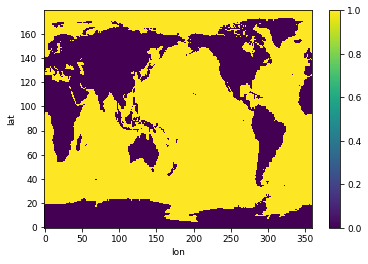

In [11]:
zmask = xr.DataArray(np.ones(len(depth)),dims='depth',coords={'depth':depth})
zmask = zmask.where(depth<400.).fillna(0.)

rmask = xr.DataArray(np.zeros((len(depth),len(grid.lat),len(grid.lon))),dims=('depth','lat','lon'))
rmask[:,:,:] = np.where(np.isnan(WOA.O2[0,:,:,:]),0.,1.)

zwgt = (dz*rmask*zmask) / (dz*rmask*zmask).sum(dim='depth')

zwgt.sum(dim='depth').plot()

In [29]:
ddsxy = (dds * zwgt).sum(dim='depth').mean(dim='month')
ddsxy

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon          (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
Data variables:
    dphiRelo2    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    dphiReltot   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    dphiRelappx  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    dphiReltemp  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


initial plot size (display units): 6.98,3.54
Adjusting fig size:
	(W,H in): 10.00,12.00 --> 8.03,7.26
new plot size: 5.61,2.37


IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


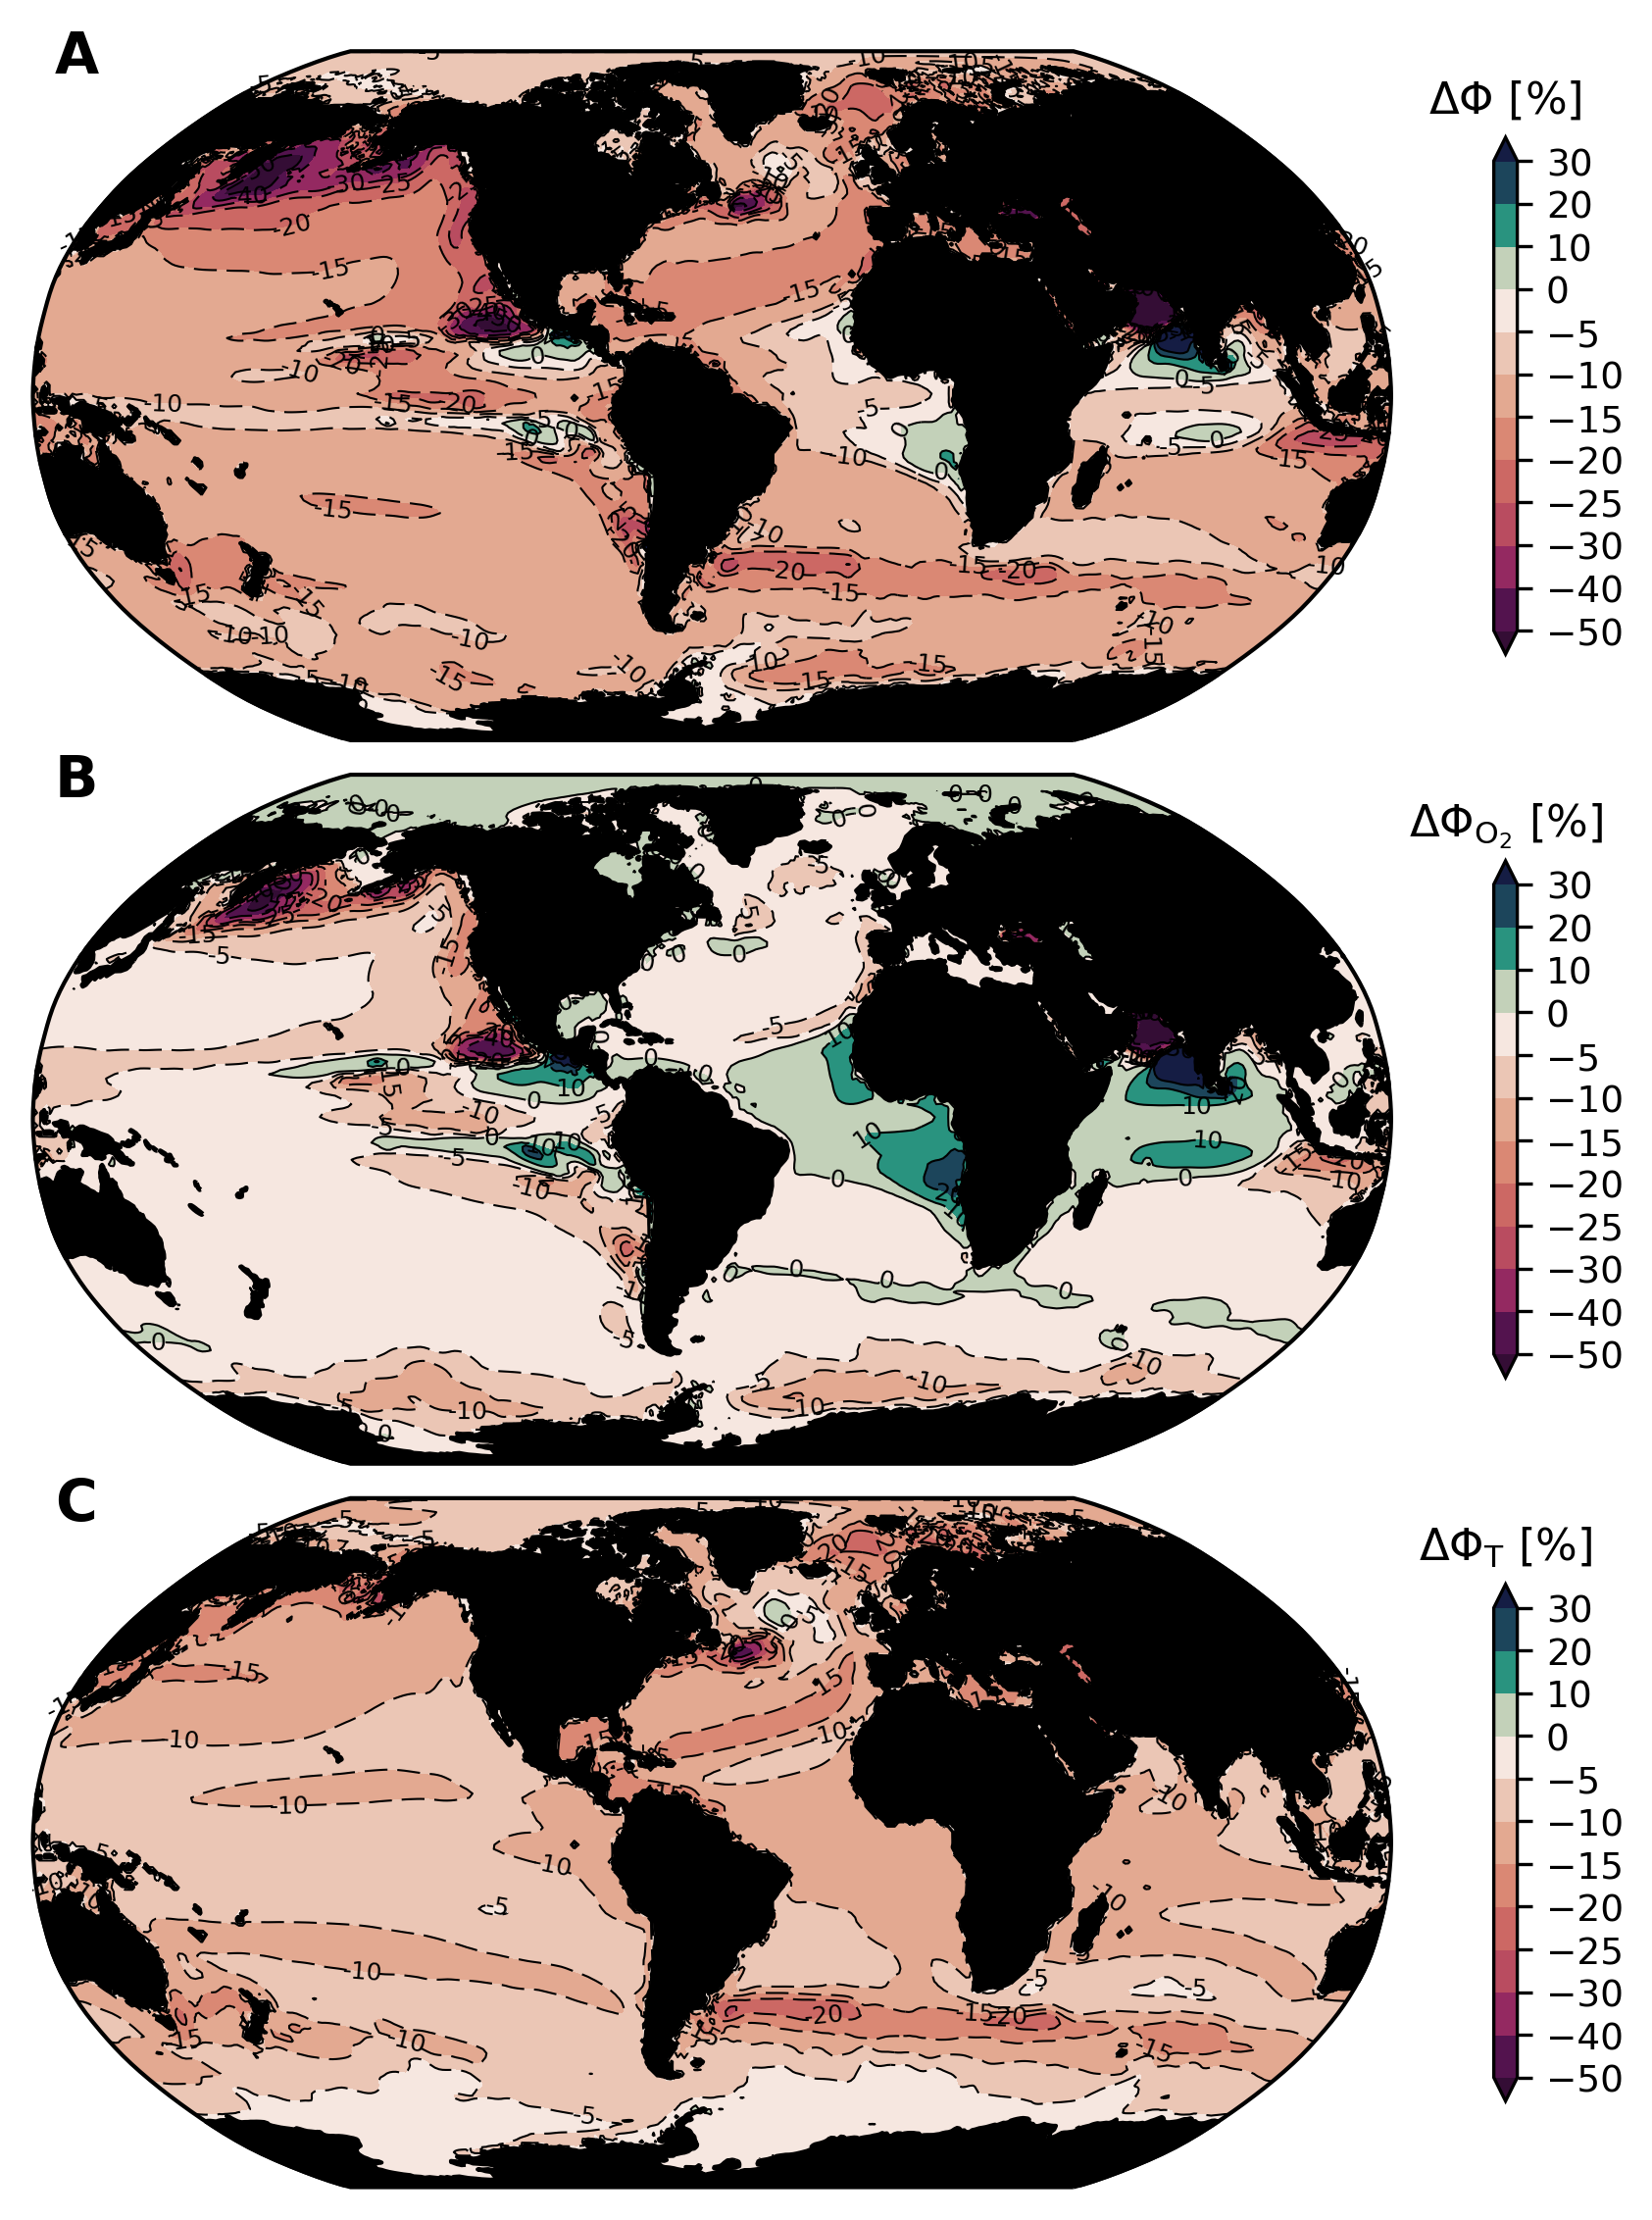

In [31]:
plot_name = os.path.join(diro['fig'],'metabolic-index-change-map.pdf')

fig=plt.figure(figsize=(10,12),dpi=300)
gs = gridspec.GridSpec(3,1)

levels = np.array([-0.5,-0.4,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0,0.1,0.2,0.3])*100.
norm = plot_tools.MidPointNorm(midpoint=0)
contour_specs = {'levels':levels,'cmap':cmocean.cm.curl_r,'norm':norm,'extend':'both'}

units = ['$\Delta\Phi$ [%]','$\Delta\Phi_{O_2}$ [%]','$\Delta\Phi_{T}$ [%]']
obj = [[]]*3
ax = []
for i,v in enumerate(['dphiReltot','dphiRelo2','dphiReltemp']):

    z = ddsxy[v].values * 100.
    lat = ddsxy.lat.values
    lon = ddsxy.lon.values

    lon = np.where(lon<0.,lon+360.,lon)
    I = np.argsort(lon)
    lon = lon[I]
    z = z[:,I]
    z,lon = add_cyclic_point(z,coord=lon)

    obj[i] = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                                contour_specs,
                                                units = units[i],
                                                fig=fig,
                                                gridspec=gs,
                                                row=i,col=0)
    ax.append(obj[i]['ax'])
    
gridspec_kwargs = {'hspace' : 0.05,
                   'wspace' : 0.05,
                   'left' : 0.,
                   'right' : 0.87,
                   'bottom' : 0.,
                   'top' : 1.}
fgsz = plot_tools.plotgrid(fig, gs, ax, [2,1],gridspec_kwargs)

alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1-0.01
    x = p.x0+0.13
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')    
plt.savefig(plot_name,bbox_inches='tight')

In [39]:
ddsyz = dds.mean(dim='lon').mean(dim='month')
ddsyz

<xarray.Dataset>
Dimensions:      (depth: 33, lat: 180)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * depth        (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 ...
Data variables:
    dphiRelo2    (depth, lat) float64 nan nan nan nan nan nan nan nan nan ...
    dphiReltot   (depth, lat) float64 nan nan nan nan nan nan nan nan nan ...
    dphiRelappx  (depth, lat) float64 nan nan nan nan nan nan nan nan nan ...
    dphiReltemp  (depth, lat) float64 nan nan nan nan nan nan nan nan nan ...

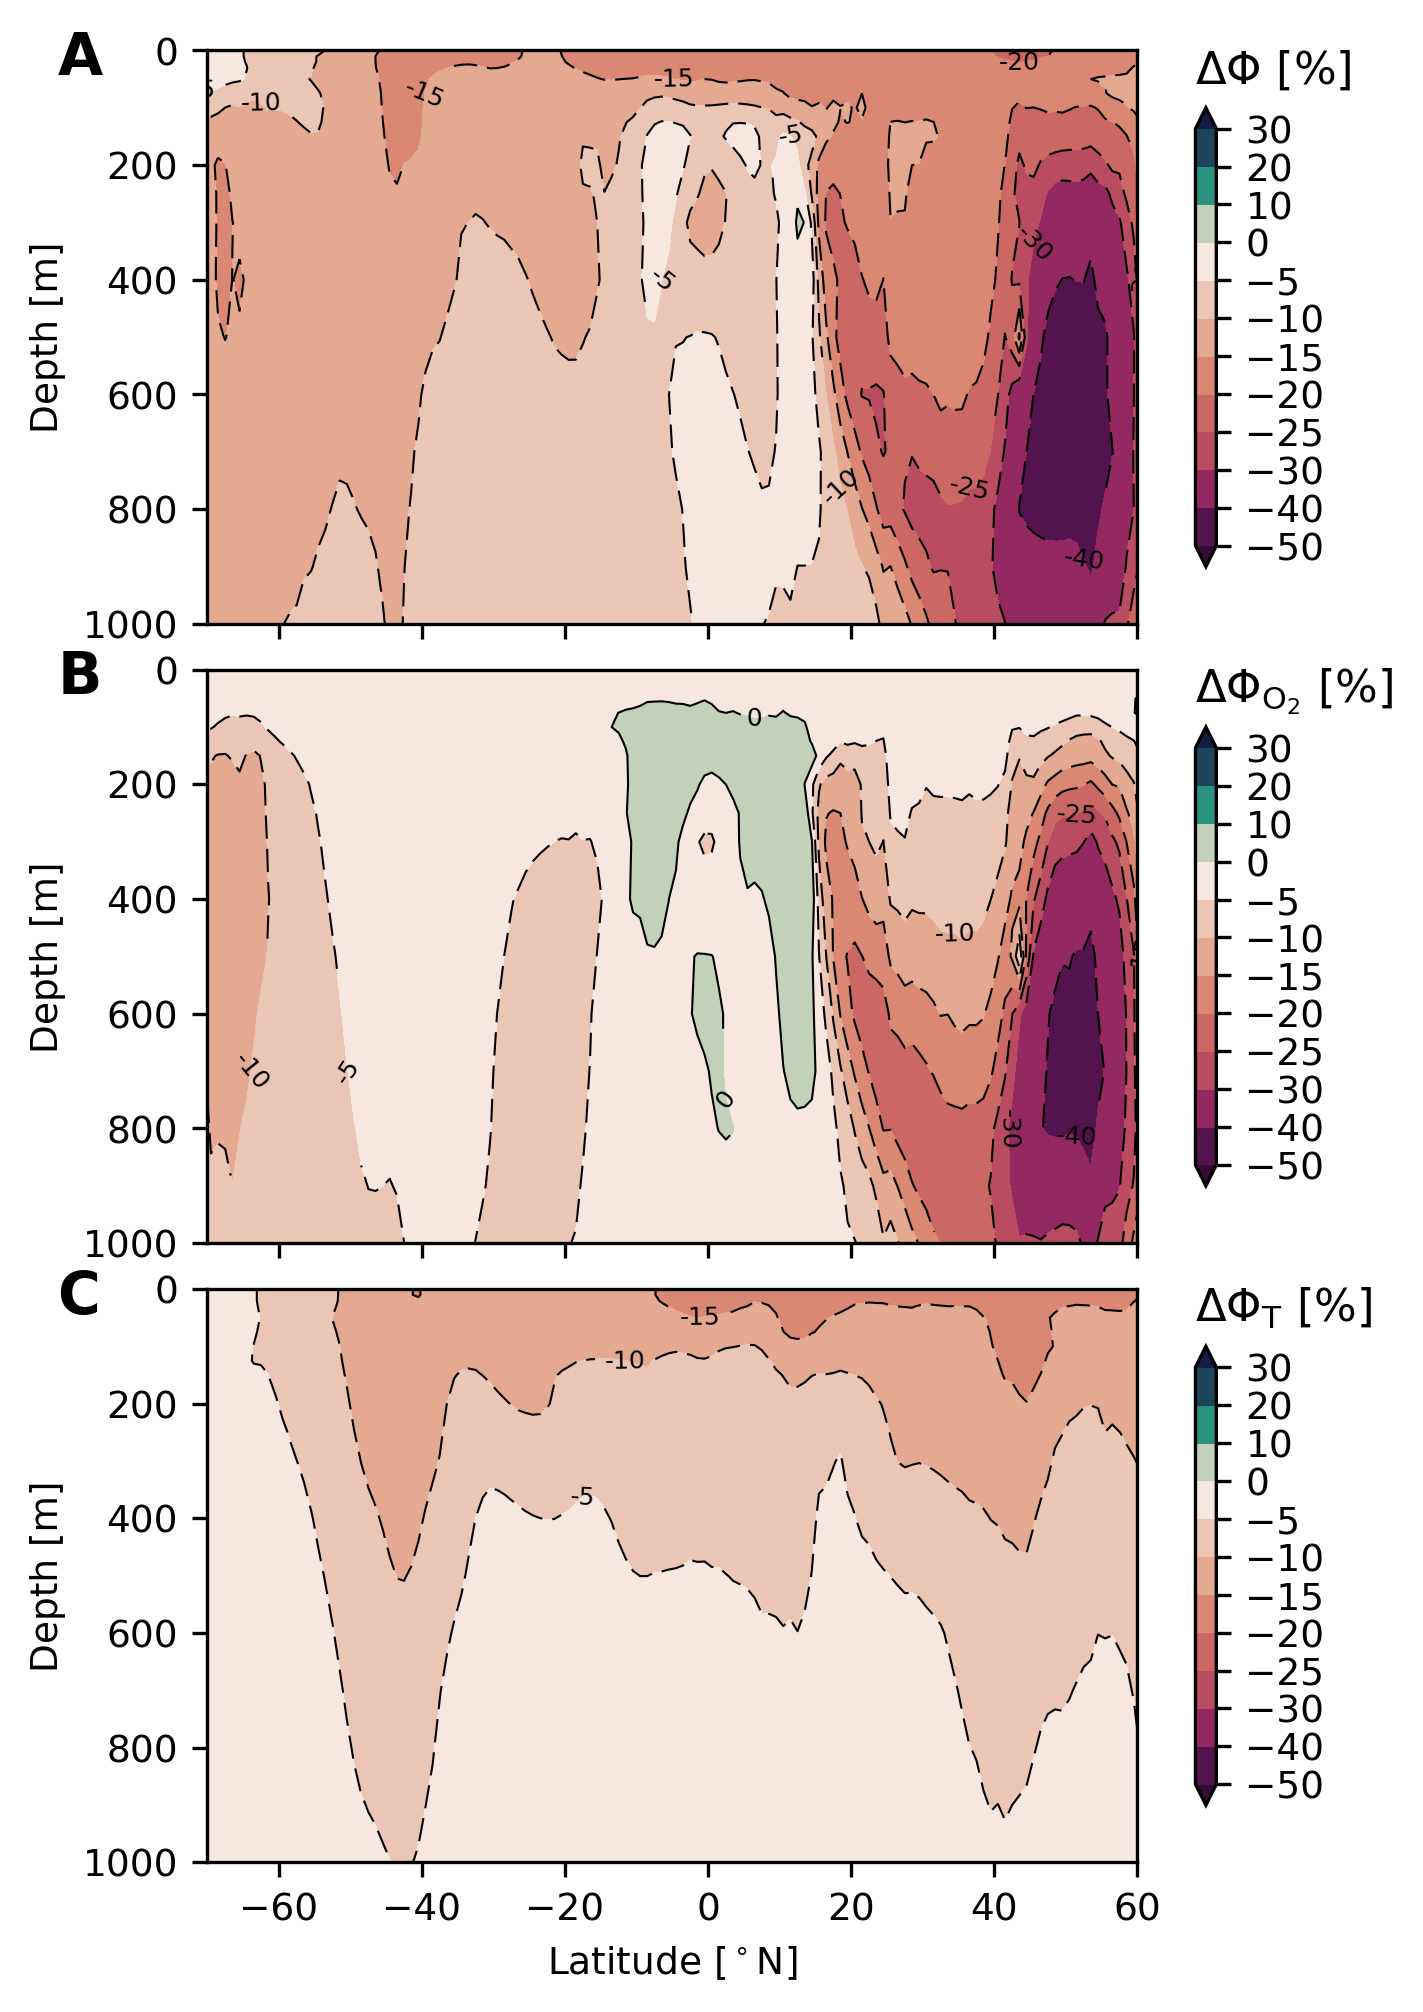

In [51]:
plot_name = os.path.join(diro['fig'],'metabolic-index-change-zonal.pdf')

fig=plt.figure(figsize=(5,8),dpi=300)
gs = gridspec.GridSpec(3,1)

levels = np.array([-0.5,-0.4,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0,0.1,0.2,0.3])*100.
norm = plot_tools.MidPointNorm(midpoint=0)
contour_specs = {'levels':levels,'cmap':cmocean.cm.curl_r,'norm':norm,'extend':'both'}

units = ['$\Delta\Phi$ [%]','$\Delta\Phi_{O_2}$ [%]','$\Delta\Phi_{T}$ [%]']
obj = [[]]*3
axs = []
for i,v in enumerate(['dphiReltot','dphiRelo2','dphiReltemp']):

    ax = fig.add_subplot(gs[i,0])

    cf = ax.contourf(ddsyz.lat, ddsyz.depth, ddsyz[v]*100., **contour_specs)  
    cs = ax.contour(ddsyz.lat, ddsyz.depth, ddsyz[v]*100., levels=levels,
                    colors='k',linewidths=0.5,zorder=100)
    cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
    fmt = '%r'
    lb = plt.clabel(cs, fontsize=6,
                   inline = True,
                   fmt=fmt)

    
    ax.set_ylim((1000.,0.))
    ax.set_xlim(-70,60)
    ax.set_ylabel('Depth [m]')
    if i < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Latitude [$^\circ$N]')
        
    cb = fig.colorbar(cf,ax = ax,
                      ticks = contour_specs['levels'],
                      orientation = 'vertical',
                      shrink = 0.8)
    cb.ax.set_title(units[i],loc='left')
    axs.append(ax)
gs.update(hspace=0.08)

alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(axs):
    p = axi.get_position()
    y = p.y1-0.01
    x = p.x0-0.1
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold') 
    
plt.savefig(plot_name,bbox_inches='tight')

In [14]:
Ao = 40.
Bn = 1.

phi = Ao * Bn * ds.pO2  / np.exp( -Eo / (ds.TEMP+constants.T0_Kelvin))
phifut = Ao * Bn * ds.pO2fut  / np.exp( -Eo / (ds.Tfut+constants.T0_Kelvin))